In [1]:
# ===========================================
# 0. Setup
# ===========================================
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_03_STATIC  = "/workspace/data/03/static"
BASE_03_DYNAMIC = "/workspace/data/03/dynamic"

plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["axes.grid"] = True

# ===========================================
# 1. Select player
# ===========================================
ATHLETE_ID = "68341b43-2561-4972-95f4-341f8530e023"
print("Target athlete:", ATHLETE_ID)

STATIC_PATH  = os.path.join(BASE_03_STATIC, ATHLETE_ID, "static_labels.parquet")
DYNAMIC_PATH = os.path.join(BASE_03_DYNAMIC, ATHLETE_ID, "dynamic_labels.parquet")

assert os.path.exists(STATIC_PATH),  f"❌ static label not found: {STATIC_PATH}"
assert os.path.exists(DYNAMIC_PATH), f"❌ dynamic label not found: {DYNAMIC_PATH}"

# ===========================================
# 2. Load labels
# ===========================================
df_static  = pd.read_parquet(STATIC_PATH)
df_dynamic = pd.read_parquet(DYNAMIC_PATH)

df_static["date_"]  = pd.to_datetime(df_static["date_"])
df_dynamic["date_"] = pd.to_datetime(df_dynamic["date_"])

print("static columns:", df_static.columns.tolist())
print("dynamic columns:", df_dynamic.columns.tolist())
print("static :", df_static.shape)
print("dynamic:", df_dynamic.shape)


Target athlete: 68341b43-2561-4972-95f4-341f8530e023
static columns: ['date_', 'static_score', 'static_thr', 'static_anomaly', 'top_features', 'athlete_id', 'method', 'params']
dynamic columns: ['date_', 'dyn_error', 'season_block', 'season_reset_zone', 'static_anomaly', 'dyn_thr', 'dyn_anomaly', 'dyn_streak', 'athlete_id', 'method', 'params']
static : (346, 8)
dynamic: (317, 11)


In [2]:
# ===========================================
# 3. Merge static & dynamic（衝突対策版）
# ===========================================

# 1) df_dynamic に static_* が既に入ってたら落とす（衝突回避）
drop_cols = [c for c in ["static_anomaly", "static_score", "static_thr", "top_features"] if c in df_dynamic.columns]
df_dynamic_m = df_dynamic.drop(columns=drop_cols).copy()

# 2) merge
df_all = pd.merge(
    df_dynamic_m,
    df_static[[
        "date_",
        "static_anomaly",
        "static_score",
        "static_thr",
        "top_features",
    ]],
    on="date_",
    how="left",
)

df_all = df_all.sort_values("date_").reset_index(drop=True)

# static が無い日は 0 扱い
df_all["static_anomaly"] = df_all["static_anomaly"].fillna(0).astype(int)
df_all["top_features"] = df_all["top_features"].where(pd.notna(df_all["top_features"]), None)

def parse_top_features(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            return x
    return x

df_all["top_features_parsed"] = df_all["top_features"].apply(parse_top_features)

print("✅ merged columns:", df_all.columns.tolist())




✅ merged columns: ['date_', 'dyn_error', 'season_block', 'season_reset_zone', 'dyn_thr', 'dyn_anomaly', 'dyn_streak', 'athlete_id', 'method', 'params', 'static_anomaly', 'static_score', 'static_thr', 'top_features', 'top_features_parsed']



=== Effect check ===
Dynamic anomalies: 4
  - on static_anomaly days: 0 (0.0%)
  - on reset_zone days    : 0  (0.0%)
Dynamic anomaly rate: 0.0126
Max dyn_streak: 2
dyn_thr: 1.949173


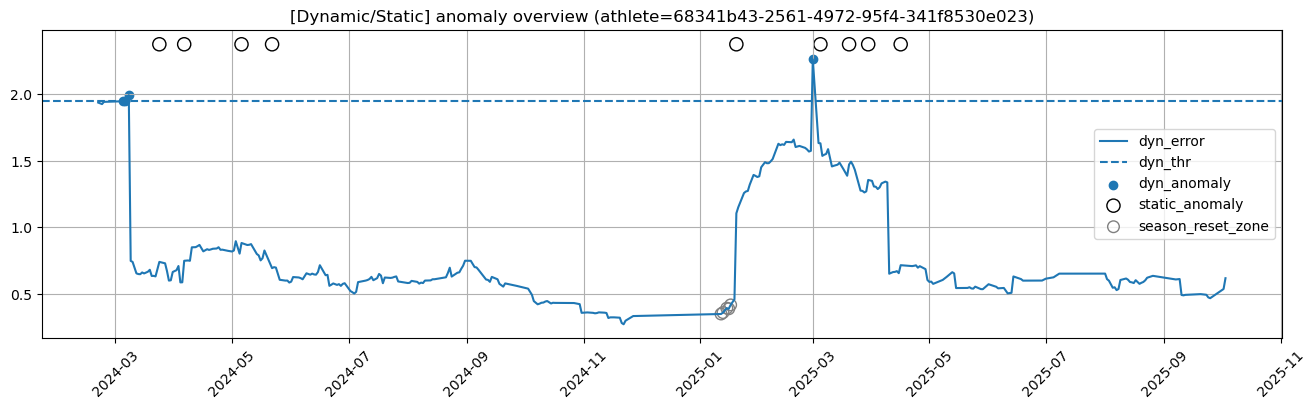

,date_,reasons
20,2024-03-24,"ima_band3_accel_count (z=+3.50), gen2_velocity..."
30,2024-04-06,"velocity_band3_total_distance (z=+3.95), metab..."
51,2024-05-06,"velocity_band3_total_distance (z=+3.63), ima_b..."
60,2024-05-22,"ima_band3_right_count (z=+8.65), heart_rate_ba..."
181,2025-01-20,metabolic_power_band6_total_distance (z=+16.12...
212,2025-03-05,"velocity2_band7_total_distance (z=+5.36), gen2..."
223,2025-03-20,"velocity2_band7_total_distance (z=+5.37), gen2..."
231,2025-03-30,gen2_velocity2_band6_total_effort_count (z=+3....
246,2025-04-16,"velocity2_band6_total_distance (z=+4.02), gen2..."


In [3]:
# ===========================================
# 4. 効果確認（数値でチェック）
# ===========================================
n_dyn = int(df_all.get("dyn_anomaly", pd.Series([], dtype=int)).sum()) if "dyn_anomaly" in df_all.columns else 0
n_dyn_on_static = int(((df_all["dyn_anomaly"] == 1) & (df_all["static_anomaly"] == 1)).sum()) if "dyn_anomaly" in df_all.columns else 0
n_dyn_on_reset  = int(((df_all["dyn_anomaly"] == 1) & (df_all["season_reset_zone"] == 1)).sum()) if ("dyn_anomaly" in df_all.columns and "season_reset_zone" in df_all.columns) else 0

print("\n=== Effect check ===")
print(f"Dynamic anomalies: {n_dyn}")
print(f"  - on static_anomaly days: {n_dyn_on_static} ({(n_dyn_on_static/max(n_dyn,1))*100:.1f}%)")
print(f"  - on reset_zone days    : {n_dyn_on_reset}  ({(n_dyn_on_reset/max(n_dyn,1))*100:.1f}%)")

if "dyn_anomaly" in df_all.columns:
    print(f"Dynamic anomaly rate: {df_all['dyn_anomaly'].mean():.4f}")
if "dyn_streak" in df_all.columns:
    print(f"Max dyn_streak: {int(df_all['dyn_streak'].max())}")

thr_val = float(df_all["dyn_thr"].dropna().iloc[0]) if "dyn_thr" in df_all.columns and df_all["dyn_thr"].notna().any() else None
if thr_val is not None:
    print(f"dyn_thr: {thr_val:.6f}")
else:
    print("⚠ dyn_thr not found or all NaN")


# ===========================================
# 5. 可視化：dyn_error + dyn_thr + anomalies
# ===========================================
plt.figure(figsize=(16,4))

if "dyn_error" in df_all.columns:
    plt.plot(df_all["date_"], df_all["dyn_error"], label="dyn_error")

if thr_val is not None:
    plt.axhline(thr_val, linestyle="--", label="dyn_thr")

if "dyn_anomaly" in df_all.columns:
    mask_dyn = df_all["dyn_anomaly"] == 1
    plt.scatter(df_all.loc[mask_dyn, "date_"], df_all.loc[mask_dyn, "dyn_error"], label="dyn_anomaly")

mask_stat = df_all["static_anomaly"] == 1
if mask_stat.any() and "dyn_error" in df_all.columns:
    y_top = df_all["dyn_error"].max() * 1.05
    plt.scatter(
        df_all.loc[mask_stat, "date_"],
        np.full(mask_stat.sum(), y_top),
        facecolors="none",
        edgecolors="black",
        s=90,
        label="static_anomaly"
    )

if "season_reset_zone" in df_all.columns and "dyn_error" in df_all.columns:
    mask_reset = df_all["season_reset_zone"] == 1
    if mask_reset.any():
        plt.scatter(
            df_all.loc[mask_reset, "date_"],
            df_all.loc[mask_reset, "dyn_error"],
            facecolors="none",
            edgecolors="gray",
            s=70,
            label="season_reset_zone"
        )

plt.title(f"[Dynamic/Static] anomaly overview (athlete={ATHLETE_ID})")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# ===========================================
# 6. Static anomaly reasons（読める形）
# ===========================================
static_days = df_all[df_all["static_anomaly"] == 1][["date_", "top_features_parsed"]].copy().sort_values("date_")

def format_reasons(x, topn=5):
    if x is None:
        return ""
    if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and "feature" in x[0]:
        items = x[:topn]
        return ", ".join([f"{d['feature']} (z={d['z']:+.2f})" for d in items if "z" in d])
    if isinstance(x, list):
        return ", ".join([str(v) for v in x[:topn]])
    return str(x)

static_days["reasons"] = static_days["top_features_parsed"].apply(format_reasons)
display(static_days[["date_", "reasons"]])

Dynamic anomaly days: 4


,dyn_anomaly_date
0,2024-03-05
1,2024-03-06
2,2024-03-08
3,2025-03-01



[Window] center=2024-03-05  (±14 days)  dyn_streak=1


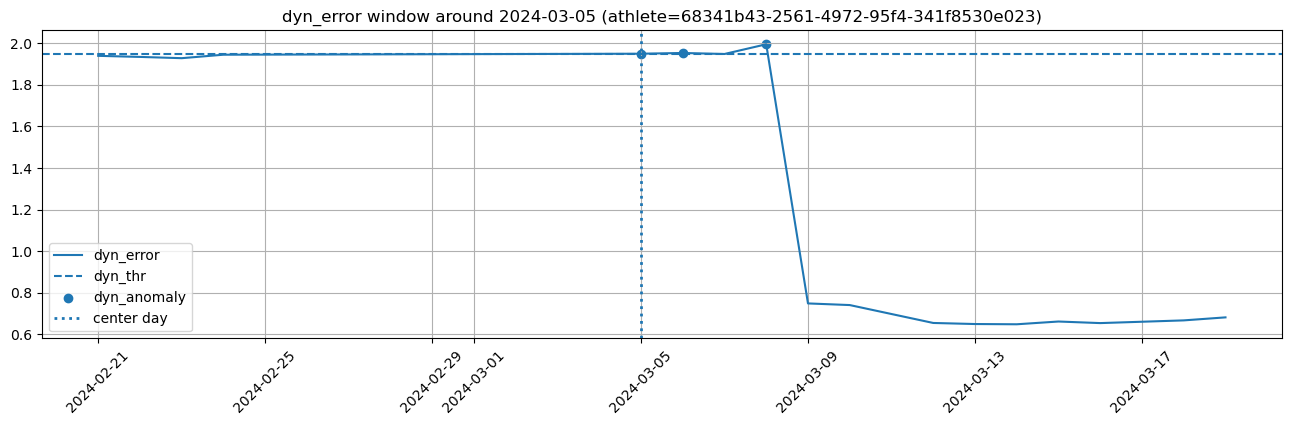

Key days in this window (dyn/static/reset): 3


,date_,dyn_error,dyn_thr,dyn_anomaly,dyn_streak,static_anomaly,season_reset_zone,season_block
4,2024-03-05,1.949199,1.949173,1,1,0,0,0
5,2024-03-06,1.952789,1.949173,1,2,0,0,0
7,2024-03-08,1.994593,1.949173,1,1,0,0,0


No static anomalies in this window.

[Window] center=2024-03-06  (±14 days)  dyn_streak=2


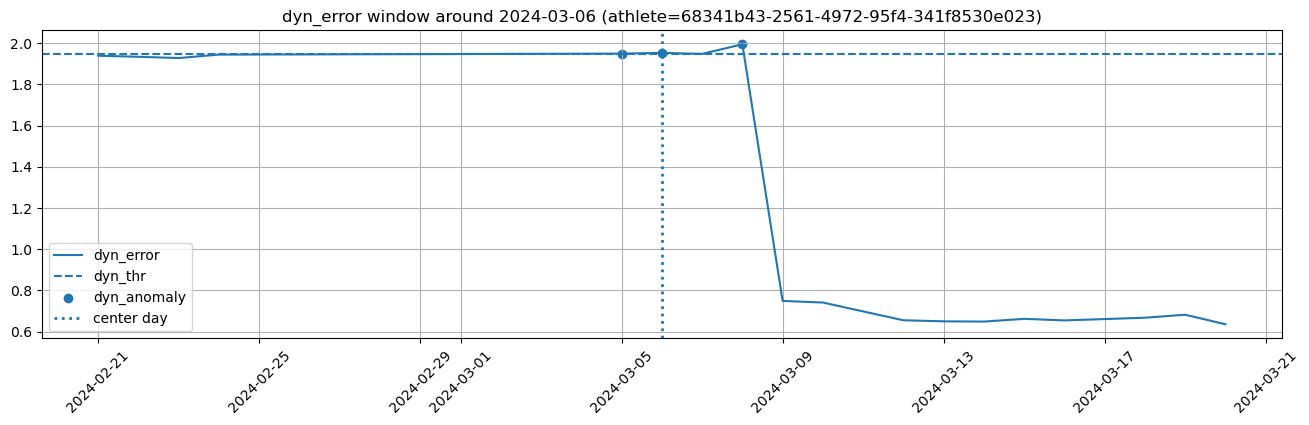

Key days in this window (dyn/static/reset): 3


,date_,dyn_error,dyn_thr,dyn_anomaly,dyn_streak,static_anomaly,season_reset_zone,season_block
4,2024-03-05,1.949199,1.949173,1,1,0,0,0
5,2024-03-06,1.952789,1.949173,1,2,0,0,0
7,2024-03-08,1.994593,1.949173,1,1,0,0,0


No static anomalies in this window.

[Window] center=2024-03-08  (±14 days)  dyn_streak=1


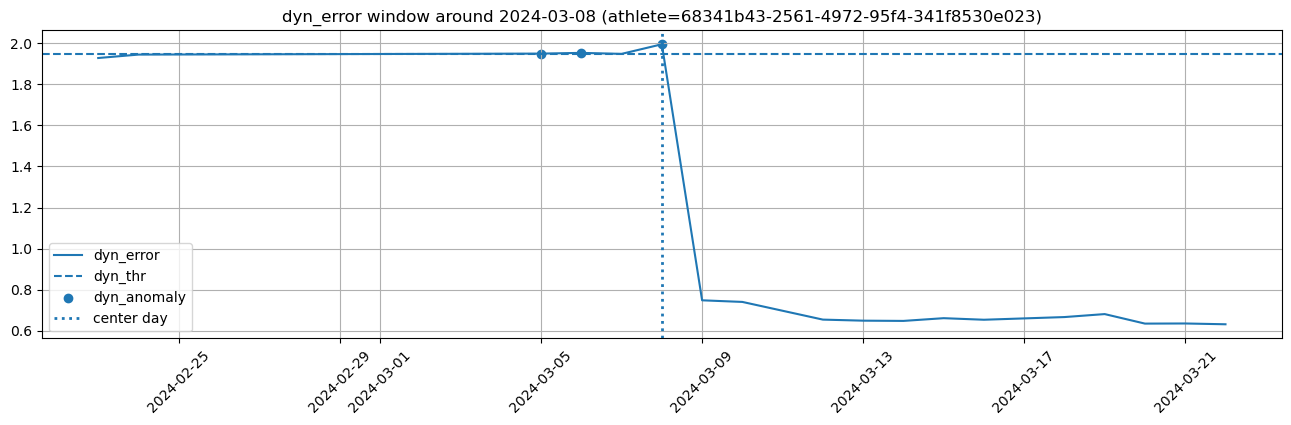

Key days in this window (dyn/static/reset): 3


,date_,dyn_error,dyn_thr,dyn_anomaly,dyn_streak,static_anomaly,season_reset_zone,season_block
4,2024-03-05,1.949199,1.949173,1,1,0,0,0
5,2024-03-06,1.952789,1.949173,1,2,0,0,0
7,2024-03-08,1.994593,1.949173,1,1,0,0,0


No static anomalies in this window.

[Window] center=2025-03-01  (±14 days)  dyn_streak=1


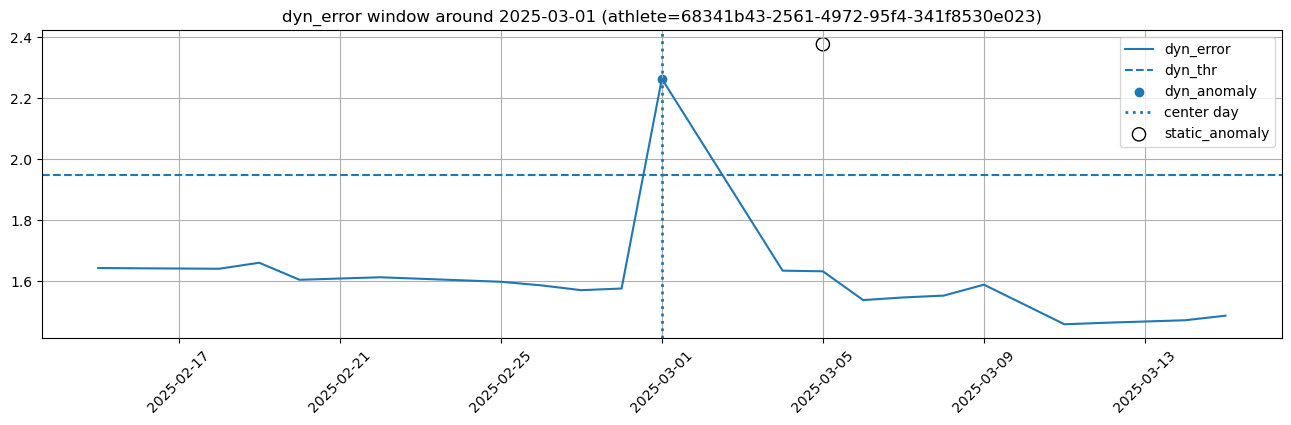

Key days in this window (dyn/static/reset): 2


,date_,dyn_error,dyn_thr,dyn_anomaly,dyn_streak,static_anomaly,season_reset_zone,season_block
210,2025-03-01,2.264248,1.949173,1,1,0,0,1
212,2025-03-05,1.632737,1.949173,0,0,1,0,1


Static anomaly reasons in this window:


,date_,reasons
212,2025-03-05,"velocity2_band7_total_distance (z=+5.36), gen2..."


In [4]:
# ===========================================
# Player: dyn anomaly window view (±N days)
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- 前提：df_all が merge 済みで、以下列があること
# date_, dyn_error, dyn_thr, dyn_anomaly, dyn_streak,
# static_anomaly, top_features_parsed, season_reset_zone

WINDOW_DAYS = 14  # ±何日見るか

assert "date_" in df_all.columns, "df_all not found / date_ missing"
df_all = df_all.sort_values("date_").reset_index(drop=True)

# dyn_thr は基本一定のはず（ブロック内）
thr_val = float(df_all["dyn_thr"].dropna().iloc[0]) if "dyn_thr" in df_all.columns and df_all["dyn_thr"].notna().any() else None

# 1) dynamic anomaly の日付一覧
dyn_days = df_all.loc[df_all["dyn_anomaly"] == 1, "date_"].dropna().sort_values().unique()
print(f"Dynamic anomaly days: {len(dyn_days)}")
display(pd.DataFrame({"dyn_anomaly_date": dyn_days}))

if len(dyn_days) == 0:
    print("No dynamic anomalies for this athlete.")
else:
    for d in dyn_days:
        start = pd.to_datetime(d) - pd.Timedelta(days=WINDOW_DAYS)
        end   = pd.to_datetime(d) + pd.Timedelta(days=WINDOW_DAYS)

        w = df_all[(df_all["date_"] >= start) & (df_all["date_"] <= end)].copy()
        if len(w) == 0:
            continue

        # ---- 見出し ----
        streak_val = int(w.loc[w["date_"] == pd.to_datetime(d), "dyn_streak"].max()) if "dyn_streak" in w.columns else None
        print("\n" + "="*90)
        print(f"[Window] center={pd.to_datetime(d).date()}  (±{WINDOW_DAYS} days)  dyn_streak={streak_val}")

        # ---- グラフ ----
        plt.figure(figsize=(16,4))

        if "dyn_error" in w.columns:
            plt.plot(w["date_"], w["dyn_error"], label="dyn_error")

        if thr_val is not None:
            plt.axhline(thr_val, linestyle="--", label="dyn_thr")

        # 動的異常点（窓内）
        if "dyn_anomaly" in w.columns:
            m_dyn = w["dyn_anomaly"] == 1
            plt.scatter(w.loc[m_dyn, "date_"], w.loc[m_dyn, "dyn_error"], label="dyn_anomaly")

        # 中心日を縦線で強調
        plt.axvline(pd.to_datetime(d), linestyle=":", linewidth=2, label="center day")

        # static anomaly（上部リング）
        m_stat = w["static_anomaly"] == 1 if "static_anomaly" in w.columns else np.zeros(len(w), dtype=bool)
        if m_stat.any() and "dyn_error" in w.columns:
            y_top = w["dyn_error"].max() * 1.05
            plt.scatter(
                w.loc[m_stat, "date_"],
                np.full(m_stat.sum(), y_top),
                facecolors="none",
                edgecolors="black",
                s=90,
                label="static_anomaly"
            )

        # reset zone（灰リング）
        if "season_reset_zone" in w.columns and "dyn_error" in w.columns:
            m_reset = w["season_reset_zone"] == 1
            if m_reset.any():
                plt.scatter(
                    w.loc[m_reset, "date_"],
                    w.loc[m_reset, "dyn_error"],
                    facecolors="none",
                    edgecolors="gray",
                    s=70,
                    label="season_reset_zone"
                )

        plt.title(f"dyn_error window around {pd.to_datetime(d).date()} (athlete={ATHLETE_ID})")
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

        # ---- 窓内のサマリ表（dyn/static）----
        cols = ["date_"]
        for c in ["dyn_error", "dyn_thr", "dyn_anomaly", "dyn_streak", "static_anomaly", "season_reset_zone", "season_block"]:
            if c in w.columns:
                cols.append(c)

        w_sum = w[cols].copy()
        w_sum = w_sum[(w_sum.get("dyn_anomaly", 0) == 1) | (w_sum.get("static_anomaly", 0) == 1) | (w_sum.get("season_reset_zone", 0) == 1)]
        w_sum = w_sum.sort_values("date_")
        print("Key days in this window (dyn/static/reset):", len(w_sum))
        display(w_sum)

        # ---- 窓内の static 理由 ----
        if "top_features_parsed" in w.columns:
            w_stat = w[w.get("static_anomaly", 0) == 1][["date_", "top_features_parsed"]].copy().sort_values("date_")

            def format_reasons(x, topn=5):
                if x is None:
                    return ""
                if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and "feature" in x[0]:
                    items = x[:topn]
                    return ", ".join([f"{d['feature']} (z={d['z']:+.2f})" for d in items if "z" in d])
                if isinstance(x, list):
                    return ", ".join([str(v) for v in x[:topn]])
                return str(x)

            if len(w_stat) > 0:
                w_stat["reasons"] = w_stat["top_features_parsed"].apply(format_reasons)
                print("Static anomaly reasons in this window:")
                display(w_stat[["date_", "reasons"]])
            else:
                print("No static anomalies in this window.")
